In [124]:
### Import important Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import random
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from scipy.sparse import hstack

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from textblob import TextBlob
from profanity_check import predict, predict_prob
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from wordcloud import WordCloud, STOPWORDS

In [4]:
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm_notebook
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# !pip install profanity-check
# !pip install wordcloud

In [8]:
predict_prob(['go to hell, you scum'])[0]

0.7618860998848836

In [6]:
os.chdir(r'C:\Users\gurvinder1.singh\Downloads\Data\HE_Accen_dataset')

In [7]:
os.listdir()

['HE_Accen_dataset.rar',
 'sample_submission.csv',
 'submission.csv',
 'test.csv',
 'train.csv']

In [8]:
sub=pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')

### Data Exploarion

In [27]:
train.shape
test.shape

(45000, 5)

(30000, 4)

In [121]:
train.head()

,UID,comment,date,parent_comment,score,parent_text_sent,comment_text_sent,parent_comm_profanity,comment_text_profanity,parent_comm_len,parent_comm_len1,comment_len,comment_len1
0,Tr-1,NC and NH.,2016-10,"Yeah, I get that argument. At this point, I'd ...",2,0.000000,0.000000,0.066073,0.111223,80,17,10,3
1,Tr-2,You do know west teams play against west teams...,2016-11,The blazers and Mavericks (The wests 5 and 6 s...,-4,0.233333,0.392857,0.050040,0.048015,134,27,74,14
2,Tr-3,"They were underdogs earlier today, but since G...",2016-09,They're favored to win.,3,0.800000,0.000000,0.118651,0.046734,23,4,121,19
3,Tr-4,"This meme isn't funny none of the ""new york ni...",2016-10,deadass don't kill my buzz,-8,0.000000,0.193182,0.599722,0.447639,26,5,60,12
4,Tr-5,I could use one of those tools.,2016-12,Yep can confirm I saw the tool they use for th...,6,0.000000,0.000000,0.041093,0.102836,85,18,31,7


In [122]:
train[train['score']<-100]

,UID,comment,date,parent_comment,score,parent_text_sent,comment_text_sent,parent_comm_profanity,comment_text_profanity,parent_comm_len,parent_comm_len1,comment_len,comment_len1
6010,Tr-6011,Cat.,2016-12,Cat.,-142,0.0,0.0,0.098908,0.098908,4,1,4,1
28387,Tr-28388,Stupid comment.,2016-11,Stupid title.,-188,-0.8,-0.8,0.480309,0.549627,13,2,15,2


### Data Visualizations

<Figure size 7200x7200 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

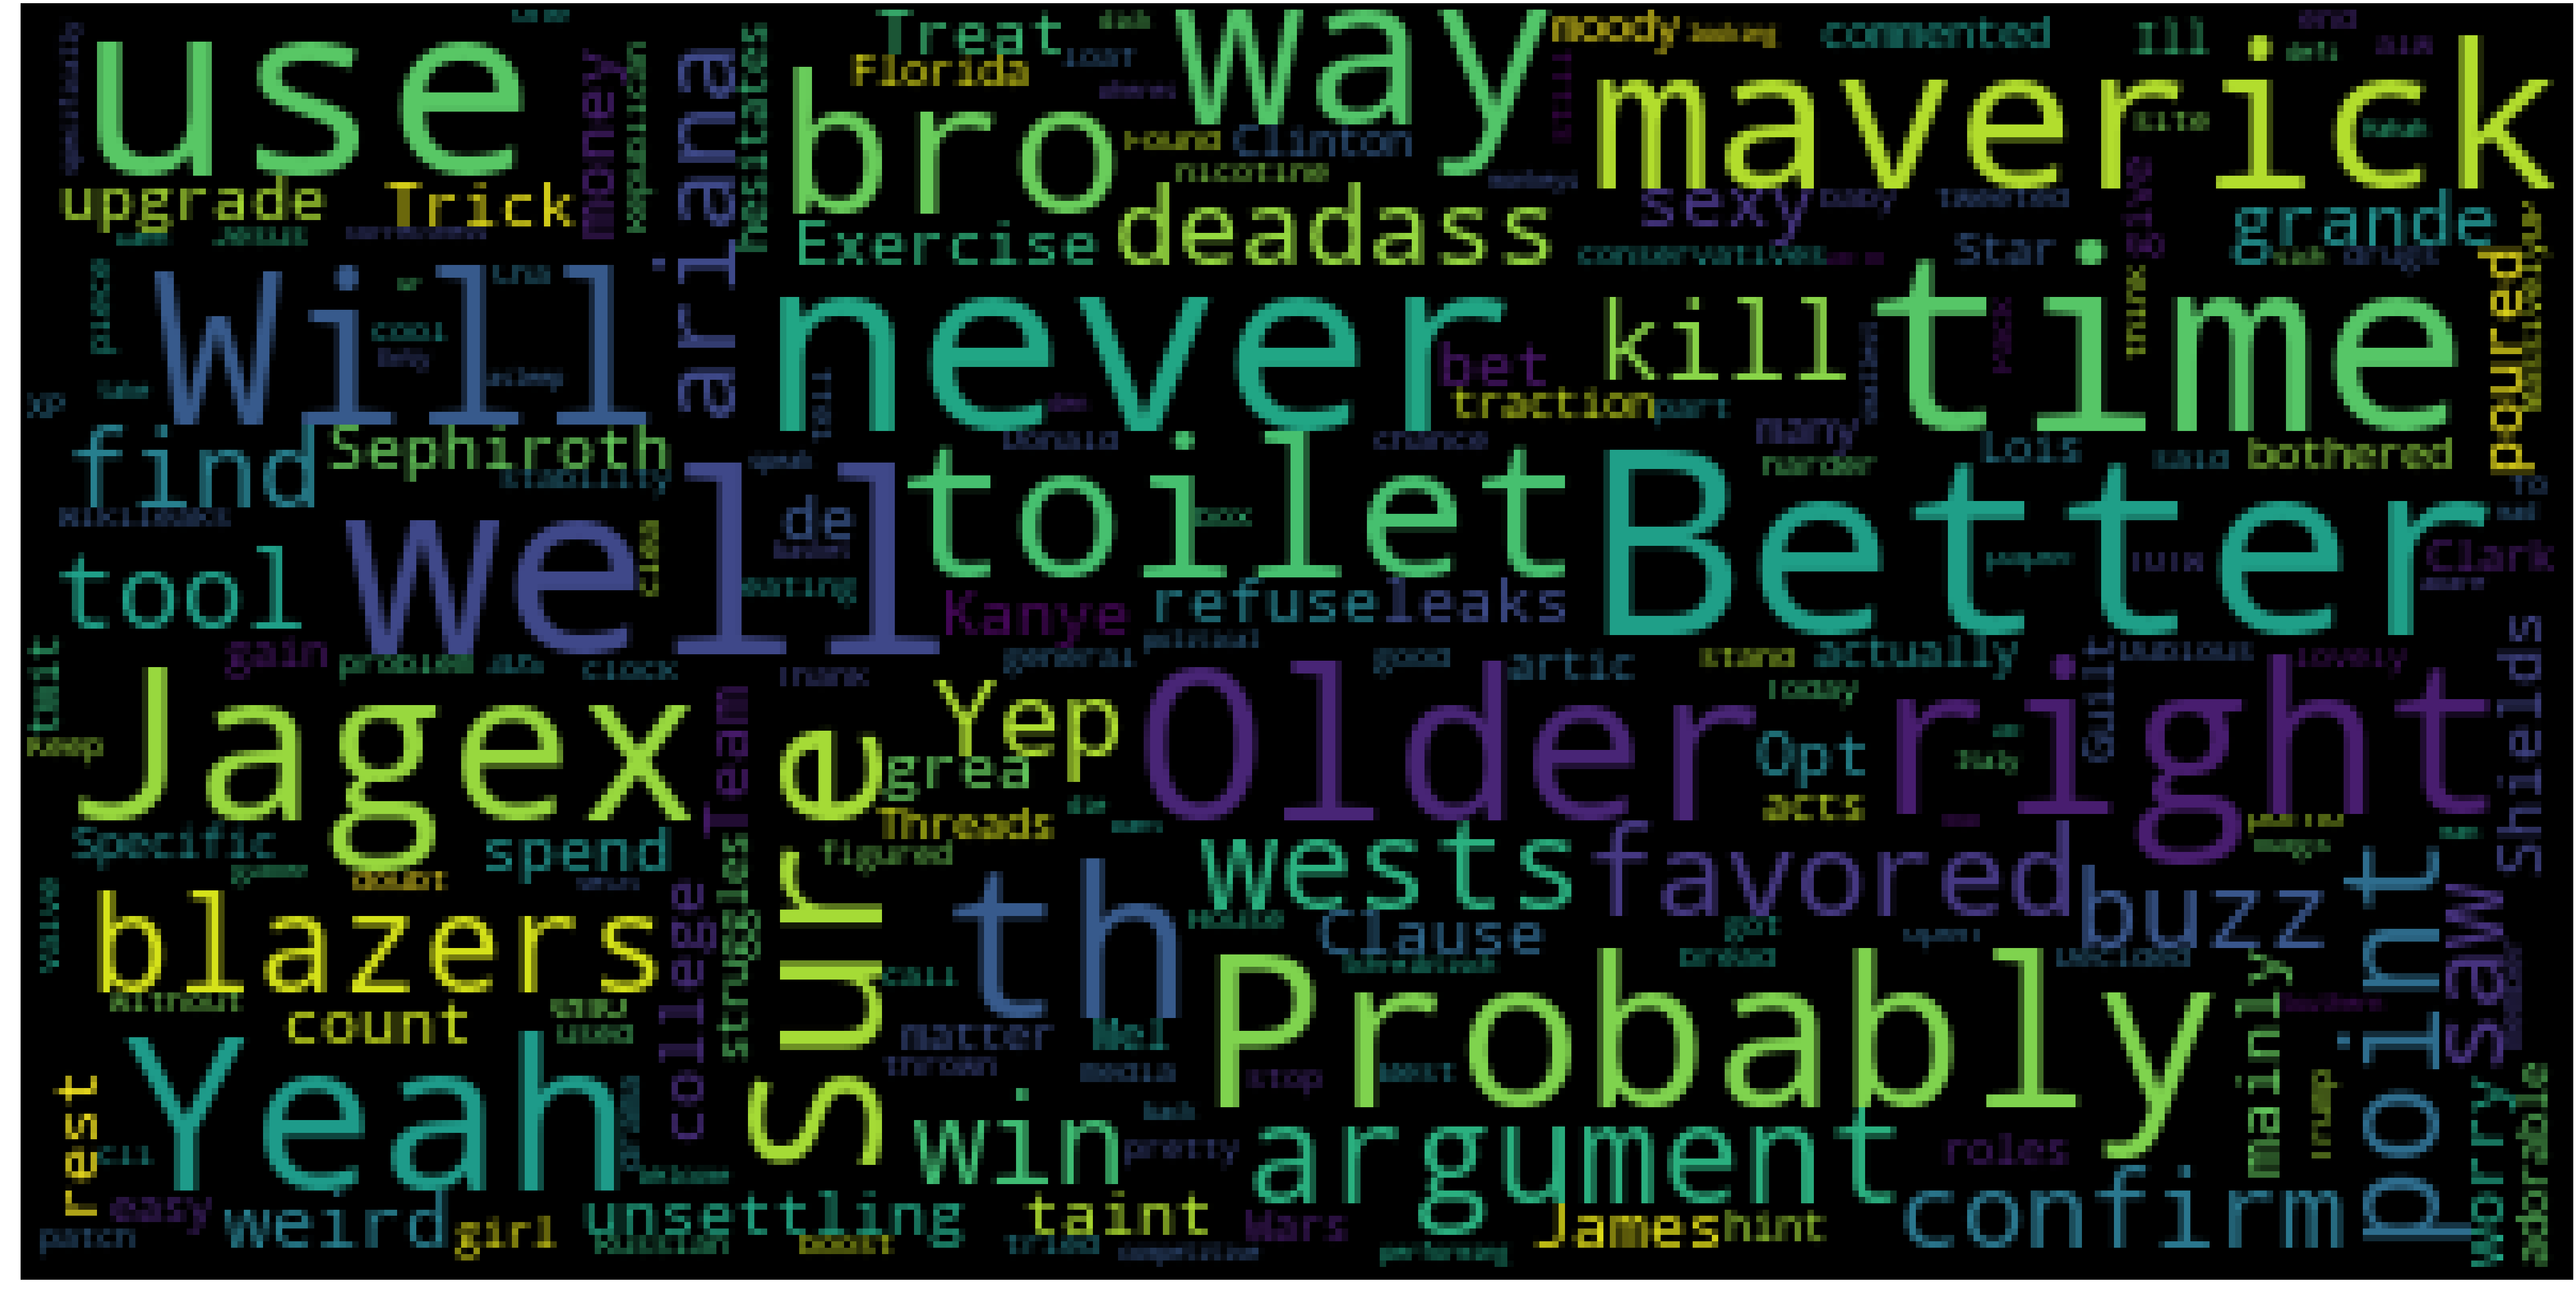

In [14]:
plt.figure(figsize = (100,100))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='black',stopwords=stopwords,max_words=200,
                          max_font_size=40, random_state=42).generate(str(train['parent_comment']))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 7200x7200 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

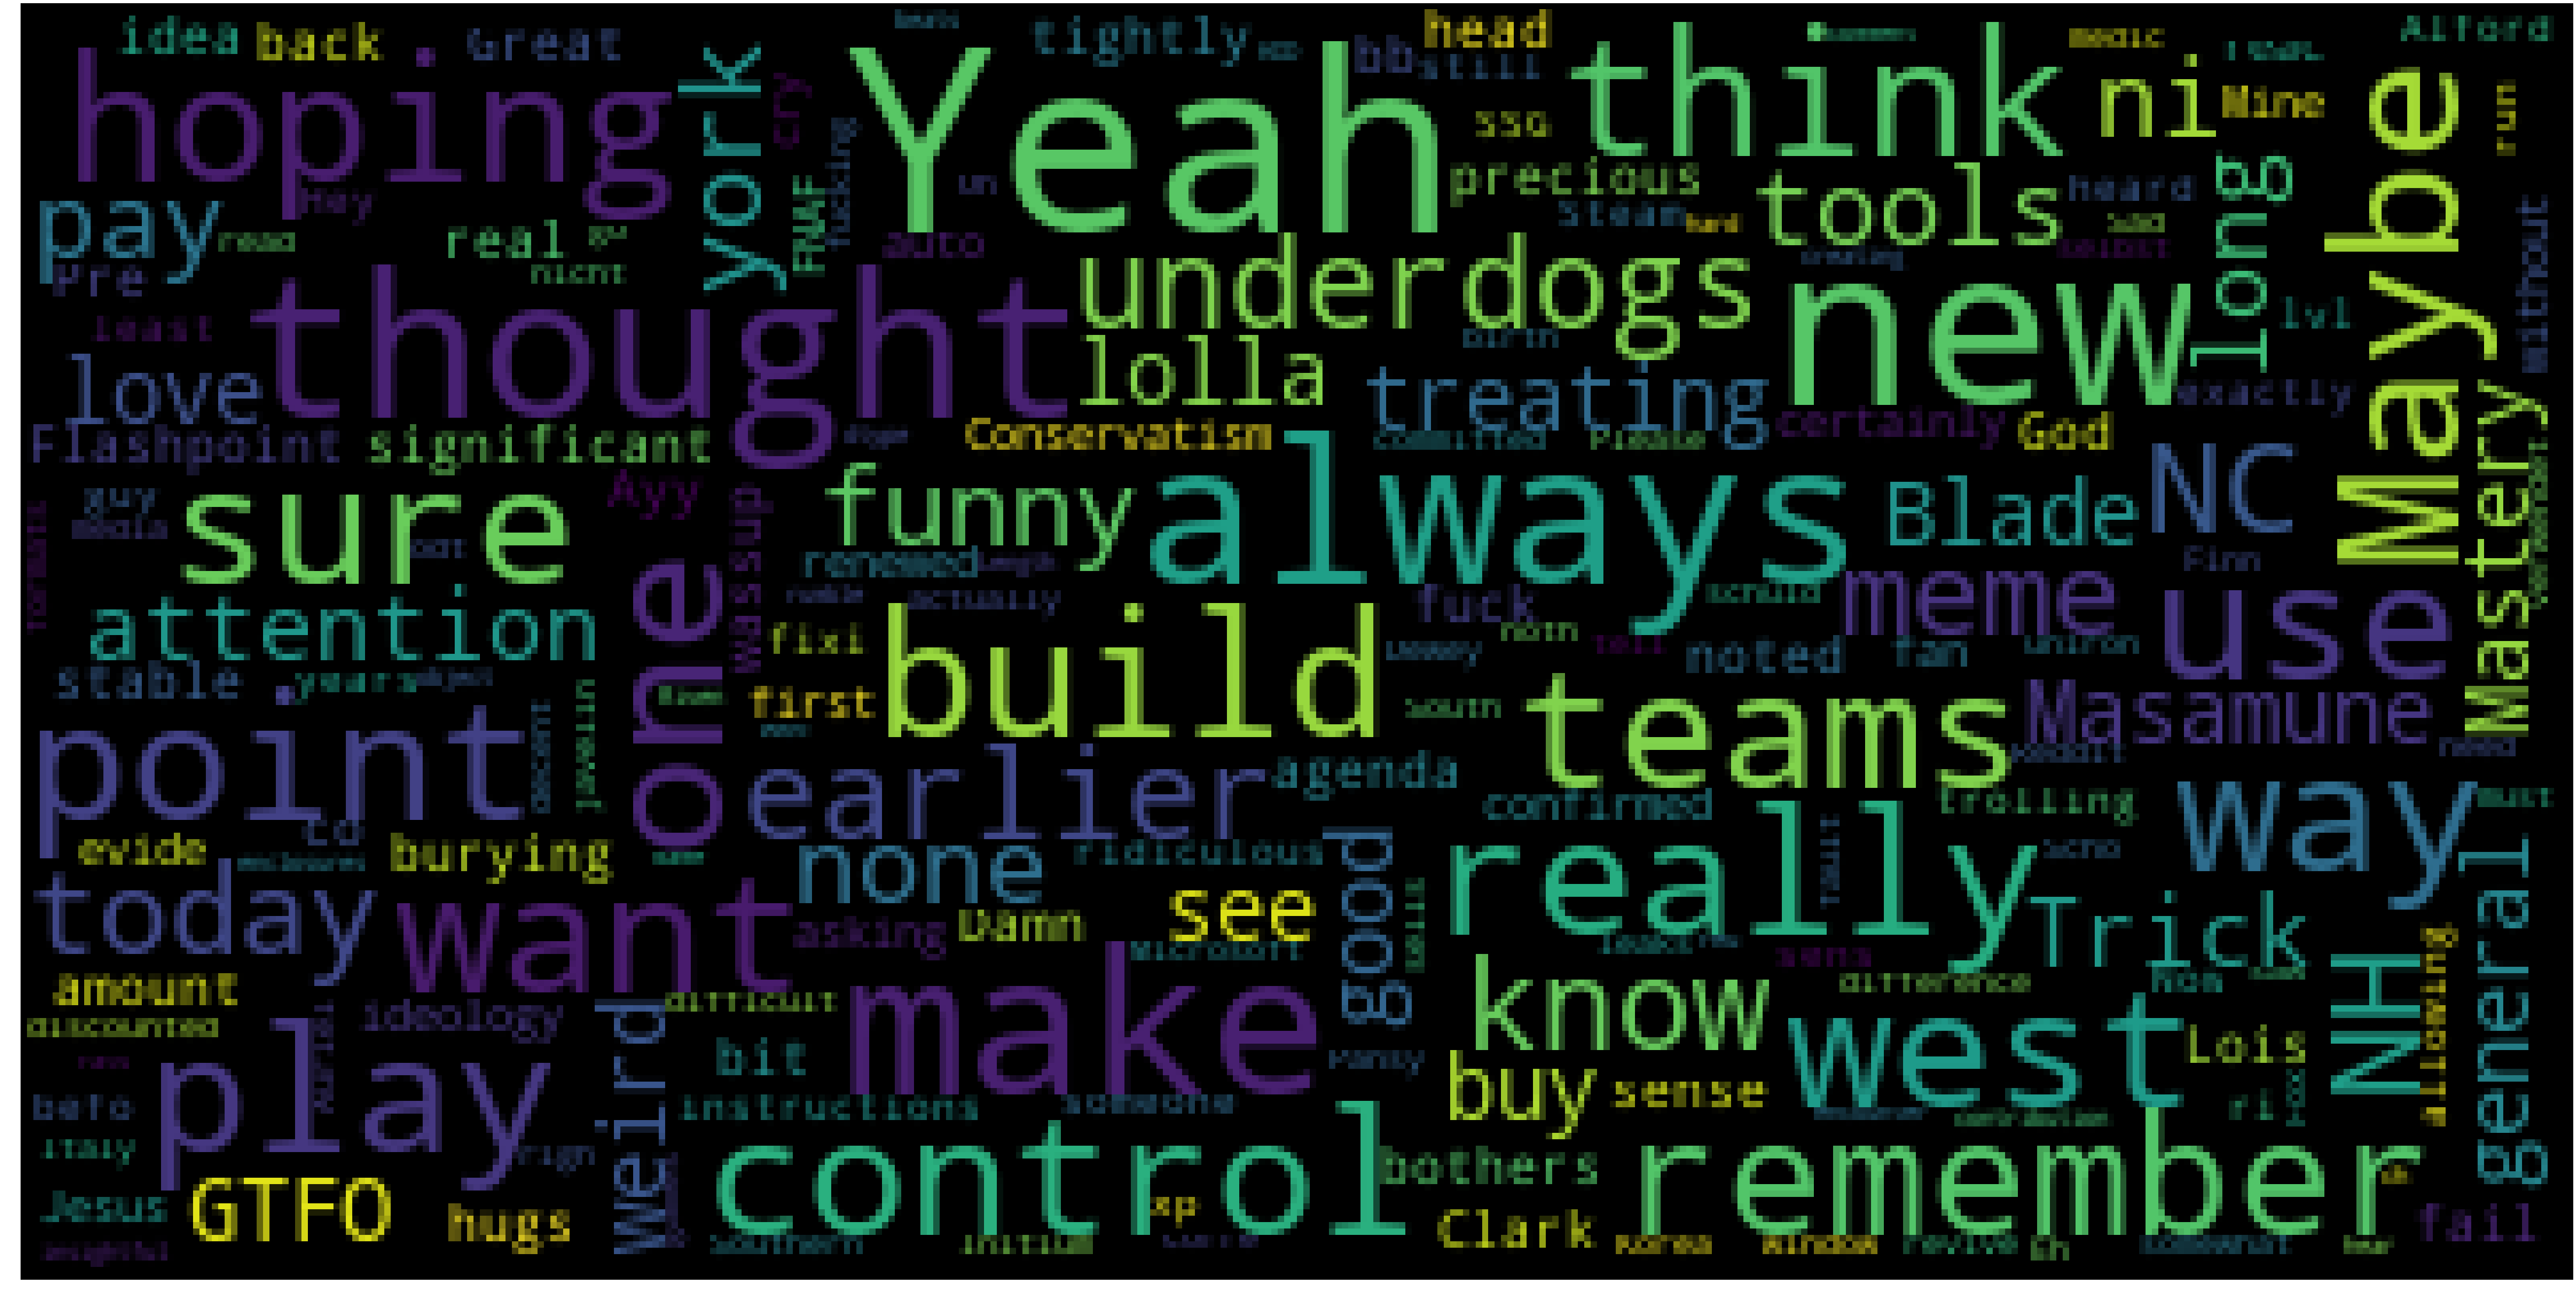

In [16]:
plt.figure(figsize = (100,100))
wordcloud = WordCloud(background_color='black',stopwords=stopwords,max_words=200,
                          max_font_size=40, random_state=42).generate(str(train['comment']))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [9]:
train['score'].value_counts()

 1       15430
 2        7250
 3        4078
 0        1923
 4        1892
 5        1832
 6        1371
 7        1070
 8         830
-1         746
 9         661
 10        569
 11        514
 12        388
-2         377
 13        377
 14        324
 15        287
 16        240
 17        233
-3         215
 18        203
 19        194
 20        170
-4         164
 22        150
 21        144
-5         127
 23        116
 24        115
         ...  
 211         1
 179         1
 1746        1
 626         1
 562         1
 338         1
 274         1
 210         1
 146         1
-142         1
-46          1
 561         1
 401         1
 241         1
 144         1
 209         1
 177         1
 145         1
-47          1
 912         1
 784         1
 720         1
 592         1
 528         1
 496         1
 432         1
 304         1
 208         1
 176         1
 1039        1
Name: score, Length: 427, dtype: int64

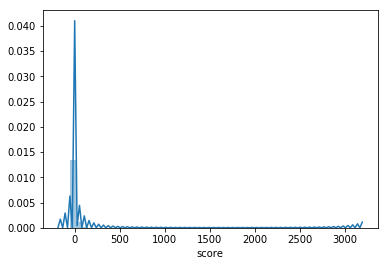

In [11]:
# sns.countplot(x="score", data=train)
sns.distplot(train['score'])

### Vectorize the both comments wordwise as well as character wise

In [36]:
train_text = train['parent_comment'] + train['comment']
test_text = test['parent_comment'] + test['comment']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [97]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
print('Char TFIDF 1/3')
train_char_features = char_vectorizer.transform(train_text)
print('Char TFIDF 2/3')
test_char_features = char_vectorizer.transform(test_text)
print('Char TFIDF 3/3')

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(2, 6), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Char TFIDF 1/3
Char TFIDF 2/3
Char TFIDF 3/3


In [37]:
ana = TextBlob("They're favored to win.")
ana.sentiment.polarity

### Checking the sentiment polarity for both comments

In [39]:
train['parent_text_sent'] = train['parent_comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
train['comment_text_sent'] = train['comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

test['parent_text_sent'] = test['parent_comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
test['comment_text_sent'] = test['comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

### Getting the Profanity for both comments

In [40]:
train['parent_comm_profanity'] = train['parent_comment'].apply(lambda x:predict_prob([x])[0])
train['comment_text_profanity'] = train['comment'].apply(lambda x:predict_prob([x])[0])

test['parent_comm_profanity'] = test['parent_comment'].apply(lambda x:predict_prob([x])[0])
test['comment_text_profanity'] = test['comment'].apply(lambda x:predict_prob([x])[0])

### Features related to word length and character length

In [41]:
train['parent_comm_len'] = train['parent_comment'].apply(lambda x:len(x))
test['parent_comm_len'] = test['parent_comment'].apply(lambda x:len(x))
train['parent_comm_len1'] = train['parent_comment'].apply(lambda x:len(x.split(' ')))
test['parent_comm_len1'] = test['parent_comment'].apply(lambda x:len(x.split(' ')))


train['comment_len'] = train['comment'].apply(lambda x:len(x))
test['comment_len'] = test['comment'].apply(lambda x:len(x))
train['comment_len1'] = train['comment'].apply(lambda x:len(x.split(' ')))
test['comment_len1'] = test['comment'].apply(lambda x:len(x.split(' ')))

### Gather all the numerical features

In [43]:
num_features = ['parent_comm_len','parent_comm_len1','comment_len','comment_len1','parent_text_sent','comment_text_sent','parent_comm_profanity','comment_text_profanity']

In [44]:
skl = MinMaxScaler()
train_num_features = csr_matrix(skl.fit_transform(train[num_features]))
test_num_features = csr_matrix(skl.fit_transform(test[num_features]))

C:\Users\gurvinder1.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\gurvinder1.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Stack all the features together

In [103]:
csr_trn = hstack([train_word_features,train_char_features,train_num_features]).tocsr()
csr_test = hstack([test_word_features,test_char_features,test_num_features]).tocsr()

In [46]:
scores = []
submission = pd.DataFrame.from_dict({'UID': test['UID']})
train_target = train['score']

### 6 Fold Cross validation

In [155]:
#create the cross validation fold for different boosting and linear model.
from sklearn.model_selection import KFold
clf = lgb.LGBMRegressor(num_leaves=58,subsample=.4,colsample_bytree=.4,max_depth=10,learning_rate=0.05,objective='regression',random_state=3,boosting_type='gbdt',seed=3,min_child_weight=np.power(10,-0.1477),reg_lambda=np.power(10,1.7570),reg_alpha=np.power(10,-2.2887),min_split_gain=np.power(10,-2.5988))
# st_train = csr_trn
# st_test = csr_test
st_train = train[num_features].values
st_test = test[num_features].values
Y=train_target

fold = 6
folds = KFold(n_splits=fold,shuffle=True, random_state=42)
X_preds = np.zeros(st_train.shape[0])
preds = np.zeros(st_test.shape[0])
for i, (tr, ts) in enumerate(folds.split(st_train)):
    print(ts.shape)
    clf.fit(st_train[tr], Y[tr])
    X_preds[ts] = clf.predict(st_train[ts])
    preds += clf.predict(st_test)
    print("fold {}, RMSE: {:.3f}".format(i, sqrt(mean_squared_error(Y[ts], X_preds[ts]))))
score = sqrt(mean_squared_error(Y, X_preds))
print(score)
preds1 = preds/fold
## 47.99436895202897 best score

(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 0, RMSE: 45.107
(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 1, RMSE: 51.169
(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 2, RMSE: 44.919
(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 3, RMSE: 42.888
(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 4, RMSE: 53.880
(7500,)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

fold 5, RMSE: 49.069
47.99436895202897


In [132]:
# classifier = lgb.LGBMRegressor(num_leaves=60,subsample=.4,colsample_bytree=.6,max_depth=2,learning_rate=0.1,objective='regression',random_state=3,boosting_type='gbdt',seed=3,min_child_weight=np.power(10,-0.1477),reg_lambda=np.power(10,1.7570),reg_alpha=np.power(10,-2.2887),min_split_gain=np.power(10,-2.5988))

In [112]:
### tuned parameters using Bayesian Optimization
classifier = lgb.LGBMRegressor(num_leaves=58,subsample=.4,colsample_bytree=.4,max_depth=10,learning_rate=0.05,objective='regression',random_state=3,boosting_type='gbdt',seed=3,min_child_weight=np.power(10,-0.1477),reg_lambda=np.power(10,1.7570),reg_alpha=np.power(10,-2.2887),min_split_gain=np.power(10,-2.5988))

In [133]:
classifier.fit(train[num_features], train_target)
pred = classifier.predict(test[num_features])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
       importance_type='split', learning_rate=0.1, max_depth=2,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=60, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

### DecisionTree and RandomForestRegressor

In [86]:
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(train[num_features], train_target)
pred1 = regressor.predict(test[num_features])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train[num_features], train_target)

In [104]:
classifier.fit(csr_trn, train_target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=10,
       min_child_samples=20, min_child_weight=0.7117049722679207,
       min_split_gain=0.002518836627841738, n_estimators=100, n_jobs=-1,
       num_leaves=58, objective='regression', random_state=3,
       reg_alpha=0.005143988630287732, reg_lambda=57.14786366718669,
       seed=3, silent=True, subsample=0.4, subsample_for_bin=200000,
       subsample_freq=0)

In [105]:
pred = classifier.predict(csr_test)

In [148]:
submission['score'] = preds1

In [149]:
submission.head()

,UID,score
0,Te-1,7.204825
1,Te-2,6.438453
2,Te-3,5.281995
3,Te-4,9.783425
4,Te-5,8.288048


In [108]:
### convert the prediction into integer values before submitting
submission['score'] = submission['score'].apply(lambda x:int(x))

In [150]:
submission.to_csv('submission.csv', index=False)

### Finding the Best Threshold based upon mean_squared_error

In [28]:
sub1=pd.DataFrame({'UID':train['UID'],'score':111})

In [29]:
sqrt(mean_squared_error(train['score'], sub1['score']))

113.46011399018893

In [35]:
thresholds = np.linspace(-15, 34, 50)
for i in thresholds:
    sub1=pd.DataFrame({'UID':train['UID'],'score':i})
    print(sqrt(mean_squared_error(train['score'], sub1['score'])) , i)

53.16826747851266 -15.0
52.74085197137667 -14.0
52.329057574799364 -13.0
51.93325588355371 -12.0
51.55381524840491 -11.0
51.1910994867923 -10.0
50.84546653013095 -9.0
50.517267015018405 -8.0
50.20684282711538 -7.0
49.9145256079497 -6.0
49.64063523633301 -5.0
49.38547829743746 -4.0
49.14934655381155 -3.0
48.93251543367321 -2.0
48.735242552660665 -1.0
48.557766285803 0.0
48.400304406756234 1.0
48.26305281130346 2.0
48.14618434171774 3.0
48.04984772781977 4.0
47.974166659428974 5.0
47.91923900341769 6.0
47.885136176758095 7.0
47.871902684838695 8.0
47.87955583196931 9.0
47.90808560845097 10.0
47.95745475592577 11.0
48.027599010013674 12.0
48.11842751656237 13.0
48.22982341525486 14.0
48.36164458190671 15.0
48.513724518600576 16.0
48.685873378903935 17.0
48.877879113834986 18.0
49.08950872301195 19.0
49.32050959455576 20.0
49.57061091681912 21.0
49.839525144875395 22.0
50.126949504898725 23.0
50.432567520072446 24.0
50.75605054243944 25.0
51.0970592761136 26.0
51.45524527846181 27.0
51.830

In [156]:
### creating the submission by using best threshold value

In [ ]:
sub=pd.DataFrame({'UID':test['UID'],'score':9})

In [ ]:
sub.tail()

In [ ]:
sub.to_csv('submission.csv',index=False)